# Project 1 

## Group One: Covid 19 | Part One: Data Cleansing 

Team Members: Michael Bien, Lupita Lopez, Jinah Porter, Debra Wu

### Research Questions to Answer:

1. WORLD: Compare COVID deaths by GDP by Country: Does a higher GDP result in a lower number of COVID deaths?

2. US: Examine death rates by age group and determine is children under 10 die at a lower rate, adults 60+ at a higher rate

3. US: Compare cases/deaths by state

4. US: Does pre-COVID state GDP related to the cases/deaths in a given state

5. March shutdown, 4th of July and Memorial Day: compare 2 months of shutdown vs. reopening: how did reopening affect case and death rates? 

6. US: Is there a relationship between COVID cases/deaths and gender?

7. US: Is there a relationship between COVID cases/deaths and ethnicity?


In [2]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
import numpy as np
import requests
import gmaps
import json

from pprint import pprint

In [3]:
data = pd.read_csv("data_cdc.csv")
data.head(10)

,Data as of,Start week,End Week,State,Sex,Age group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,9/9/20,2/1/20,9/5/20,United States,All Sexes,All Ages,"175,866","1,894,447","180,095","78,446","6,671","283,199",NaN
1,9/9/20,2/1/20,9/5/20,United States,All Sexes,Under 1 year,19,"10,513",99,3,16,131,NaN
2,9/9/20,2/1/20,9/5/20,United States,All Sexes,0-17 years,88,"18,631",296,17,123,490,NaN
3,9/9/20,2/1/20,9/5/20,United States,All Sexes,1-4 years,14,"2,021",70,2,42,124,NaN
4,9/9/20,2/1/20,9/5/20,United States,All Sexes,5-14 years,29,"3,110",94,8,52,167,NaN
5,9/9/20,2/1/20,9/5/20,United States,All Sexes,15-24 years,315,"19,998",402,111,53,655,NaN
6,9/9/20,2/1/20,9/5/20,United States,All Sexes,18-29 years,765,"35,561",963,315,100,"1,503",NaN
7,9/9/20,2/1/20,9/5/20,United States,All Sexes,25-34 years,"1,360","41,370","1,513",606,151,"2,404",NaN
8,9/9/20,2/1/20,9/5/20,United States,All Sexes,30-49 years,"8,024","124,473","7,476","3,560",565,"12,427",NaN
9,9/9/20,2/1/20,9/5/20,United States,All Sexes,35-44 years,"3,542","58,523","3,377","1,547",247,"5,590",NaN


In [4]:
data.dropna(how="all", inplace=True)
data.count()
data["COVID-19 Deaths"] = data["COVID-19 Deaths"].str.replace(",","", regex=True).astype('float')
data.head()

,Data as of,Start week,End Week,State,Sex,Age group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,9/9/20,2/1/20,9/5/20,United States,All Sexes,All Ages,175866.0,"1,894,447","180,095","78,446","6,671","283,199",NaN
1,9/9/20,2/1/20,9/5/20,United States,All Sexes,Under 1 year,19.0,"10,513",99,3,16,131,NaN
2,9/9/20,2/1/20,9/5/20,United States,All Sexes,0-17 years,88.0,"18,631",296,17,123,490,NaN
3,9/9/20,2/1/20,9/5/20,United States,All Sexes,1-4 years,14.0,"2,021",70,2,42,124,NaN
4,9/9/20,2/1/20,9/5/20,United States,All Sexes,5-14 years,29.0,"3,110",94,8,52,167,NaN


In [5]:
df_US = data[data["State"] == "United States"]
df_US_all_sex = df_US[df_US["Sex"] == "All Sexes"]
df_US_all_sex.head(15)

,Data as of,Start week,End Week,State,Sex,Age group,COVID-19 Deaths,Total Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,9/9/20,2/1/20,9/5/20,United States,All Sexes,All Ages,175866.0,"1,894,447","180,095","78,446","6,671","283,199",NaN
1,9/9/20,2/1/20,9/5/20,United States,All Sexes,Under 1 year,19.0,"10,513",99,3,16,131,NaN
2,9/9/20,2/1/20,9/5/20,United States,All Sexes,0-17 years,88.0,"18,631",296,17,123,490,NaN
3,9/9/20,2/1/20,9/5/20,United States,All Sexes,1-4 years,14.0,"2,021",70,2,42,124,NaN
4,9/9/20,2/1/20,9/5/20,United States,All Sexes,5-14 years,29.0,"3,110",94,8,52,167,NaN
5,9/9/20,2/1/20,9/5/20,United States,All Sexes,15-24 years,315.0,"19,998",402,111,53,655,NaN
6,9/9/20,2/1/20,9/5/20,United States,All Sexes,18-29 years,765.0,"35,561",963,315,100,"1,503",NaN
7,9/9/20,2/1/20,9/5/20,United States,All Sexes,25-34 years,1360.0,"41,370","1,513",606,151,"2,404",NaN
8,9/9/20,2/1/20,9/5/20,United States,All Sexes,30-49 years,8024.0,"124,473","7,476","3,560",565,"12,427",NaN
9,9/9/20,2/1/20,9/5/20,United States,All Sexes,35-44 years,3542.0,"58,523","3,377","1,547",247,"5,590",NaN


In [6]:
age_group = df_US_all_sex["Age group"]
age_group

0              All Ages
1          Under 1 year
2            0-17 years
3             1-4 years
4            5-14 years
5           15-24 years
6           18-29 years
7           25-34 years
8           30-49 years
9           35-44 years
10          45-54 years
11          50-64 years
12          55-64 years
13          65-74 years
14          75-84 years
15    85 years and over
Name: Age group, dtype: object

In [7]:
death_counts = df_US_all_sex.groupby("Age group")["COVID-19 Deaths"].sum()
death_counts
#apply(list).reset_index(name="COVID-19 Deaths")

Age group
0-17 years               88.0
1-4 years                14.0
15-24 years             315.0
18-29 years             765.0
25-34 years            1360.0
30-49 years            8024.0
35-44 years            3542.0
45-54 years            9324.0
5-14 years               29.0
50-64 years           27980.0
55-64 years           22254.0
65-74 years           37684.0
75-84 years           46487.0
85 years and over     54838.0
All Ages             175866.0
Under 1 year             19.0
Name: COVID-19 Deaths, dtype: float64

In [8]:
death_by_age = pd.DataFrame({"Number of Deaths": death_counts})

#dropping a few overlap age_group columns
death_by_age2 = death_by_age.drop(["0-17 years", "18-29 years", "30-49 years", "50-64 years"])

death_by_age2.style.format({"Number of Deaths":"{:,.0f}"})

,Number of Deaths
Age group,
1-4 years,14
15-24 years,315
25-34 years,"1,360"
35-44 years,"3,542"
45-54 years,"9,324"
5-14 years,29
55-64 years,"22,254"
65-74 years,"37,684"
75-84 years,"46,487"


Text(0.5, 1.0, 'Total Number of COVID-19 Deaths based on the Age Group')

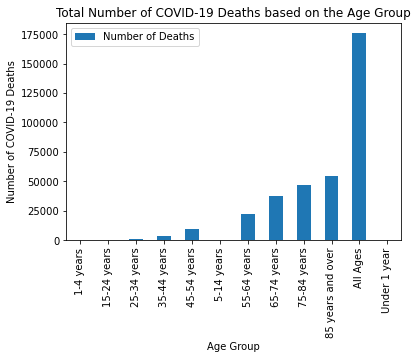

In [9]:
death_by_age2.plot(kind="bar")
plt.xlabel("Age Group")
plt.ylabel("Number of COVID-19 Deaths")
plt.title("Total Number of COVID-19 Deaths based on the Age Group")

In [10]:
df_US_male = df_US[df_US["Sex"] == "Male"]
df_US_female = df_US[df_US["Sex"] == "Female"]
df_US_unknown = df_US[df_US["Sex"] == "Unknown"]

death_counts_male = df_US_male.groupby("Age group")["COVID-19 Deaths"].sum()
death_counts_female = df_US_female.groupby("Age group")["COVID-19 Deaths"].sum()
death_counts_unknown = df_US_unknown.groupby("Age group")["COVID-19 Deaths"].sum()

death_by_sex = pd.DataFrame({"Number of Deaths (Male)": death_counts_male, 
                             "Number of Deaths (Female)": death_counts_female,
                             "Number of Deaths (Unknown)": death_counts_unknown,
                             "Total Number of Deaths": death_counts})

#dropping a few overlap age_group columns
death_by_sex2 = death_by_sex.drop(["0-17 years", "18-29 years", "30-49 years", "50-64 years"])

death_by_sex2.style.format({"Number of Deaths (Male)":"{:,.0f}", 
                           "Number of Deaths (Female)":"{:,.0f}",
                           "Number of Deaths (Unknown)":"{:,.0f}",
                           "Total Number of Deaths":"{:,.0f}"})

,Number of Deaths (Male),Number of Deaths (Female),Number of Deaths (Unknown),Total Number of Deaths
Age group,,,,
1-4 years,7,7,0,14
15-24 years,195,120,0,315
25-34 years,904,456,0,"1,360"
35-44 years,"2,430","1,112",0,"3,542"
45-54 years,"6,362","2,961",1,"9,324"
5-14 years,20,9,0,29
55-64 years,"14,493","7,761",0,"22,254"
65-74 years,"23,213","14,470",1,"37,684"
75-84 years,"25,562","20,924",1,"46,487"


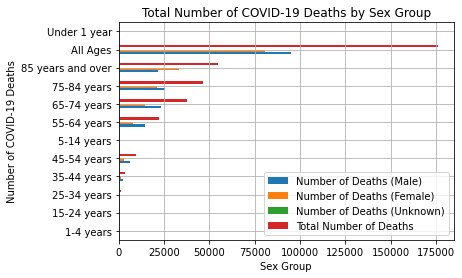

In [12]:
death_by_sex2.plot(kind="barh")

plt.xlabel("Sex Group")
plt.ylabel("Number of COVID-19 Deaths")
plt.title("Total Number of COVID-19 Deaths by Sex Group")

plt.grid(True)
plt.show(block=True)